<font color='blue'> **03__________________________________ GeostatsPy_spatial_continuity_directions** </font> 

In [1]:
import os; import sys ; from pathlib import Path    ; _R = Path("_R")   ; _R.mkdir(exist_ok=True); TA = Path('_R/03_GeostatsPy_spatial_continuity_directions_'); TA.mkdir(exist_ok=True)
import numpy as np    ; import pandas as pd ; import matplotlib.pyplot as plt ; import geostatspy.GSLIB as GSLIB   ; import geostatspy.geostats as geostats     ; import geostatspy
from ipywidgets import interactive ; from ipywidgets import widgets ; from ipywidgets import Layout ; from ipywidgets import Label ; from ipywidgets import VBox, HBox
REF1 = Path('E:/15_REPOS/02_Beta-Me/data/Krig/GeostatsPy')  ; plt.rc('axes', axisbelow=True)   ; cmap = plt.cm.inferno 
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) 
def add_grid():
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks   

In [2]:
df = pd.read_csv(REF1/'sample_data_biased.csv') ; df = df[['X','Y','Facies','Porosity']]                                                                     
df_sand = pd.DataFrame.copy(df[df['Facies'] == 1]).reset_index(drop = True) ; df_shale = pd.DataFrame.copy(df[df['Facies'] == 0]).reset_index(drop = True); df.to_csv(TA/'01_df.csv')
#df.describe().transpose()                                    

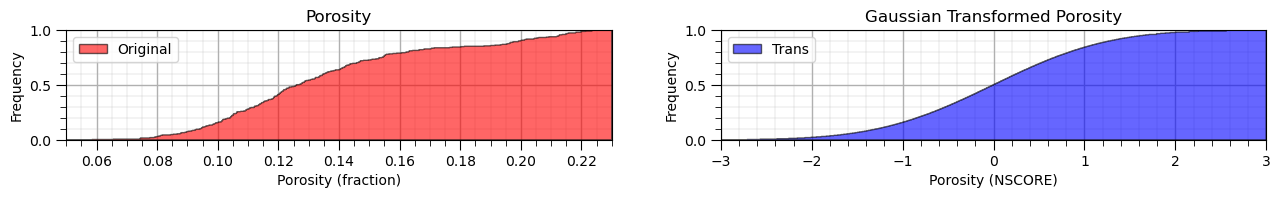

In [3]:
pormin = 0.05; pormax = 0.23  ; npormin = -3.0; npormax = 3.0       ; df['NPor'], tvPor, tnsPor = geostats.nscore(df, 'Porosity')      
fig = plt.figure(figsize=(6,1))
plt.subplot(121) ; plt.hist(df['Porosity'], facecolor='red',bins=np.linspace(pormin,pormax,1000),histtype="stepfilled",alpha=0.6,density=True,cumulative=True,edgecolor='black',label='Original')
plt.xlim([pormin,pormax]); plt.ylim([0,1.0]) ; plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Porosity') ; plt.legend(loc='upper left'); add_grid()
plt.subplot(122) ; plt.hist(df['NPor'], facecolor='blue',bins=np.linspace(npormin,npormax,1000),histtype="stepfilled",alpha=0.6,density=True,cumulative=True,edgecolor='black',label = 'Trans')
plt.xlim([npormin,npormax]); plt.ylim([0,1.0]) ; plt.xlabel('Porosity (NSCORE)'); plt.ylabel('Frequency'); plt.title('Gaussian Transformed Porosity') ; plt.legend(loc='upper left'); add_grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.3); plt.show()

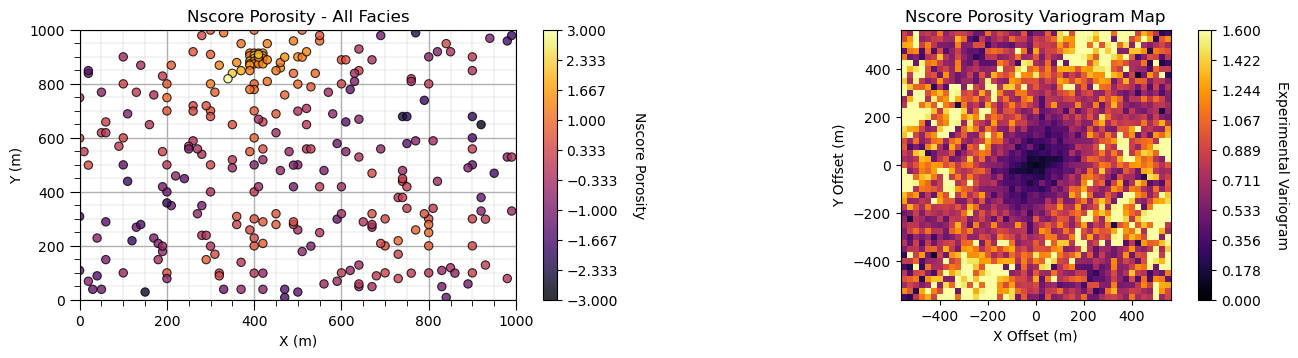

Variogram map output is (45, 45), with extents = [-562.5,562.5]


In [4]:
step = 5 ; vmin = 0; vmax = 1.6     ; lag_size = 25; nlag = 22                                          # geostats.varmapv

vmap, npmap = geostats.varmapv(df,'X','Y','NPor',tmin=-999,tmax=999,nxlag=nlag,nylag=nlag,dxlag=lag_size,dylag=lag_size,minnp=1,isill=1)       # variogram map       
xmin=-1*(nlag+0.5)*lag_size ;ymin=-1*(nlag + 0.5)*lag_size  ;xmax=(nlag+0.5)*lag_size ;ymax=(nlag+0.5)*lag_size    ;NP1=np.arange(xmin,xmax,step)  ;NP2=np.arange(ymax,ymin,-1*step)

fig = plt.figure(figsize=(6,3))
plt.subplot(121) ; GSLIB.locmap_st(df,'X','Y','NPor',0,1000,0,1000,-3,3,'Nscore Porosity - All Facies','X (m)','Y (m)','Nscore Porosity',cmap=plt.cm.inferno); add_grid()
plt.subplot(122) ; xx, yy = np.meshgrid(NP1, NP2)  ; im = plt.imshow(vmap,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = vmin, vmax = vmax ,cmap = plt.cm.inferno)

plt.title('Nscore Porosity Variogram Map'); plt.xlabel('X Offset (m)'); plt.ylabel('Y Offset (m)')    ; cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(vmin, vmax, 10))
cbar.set_label('Experimental Variogram', rotation=270, labelpad=20)        ; plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.9, wspace=0.2, hspace=0.2); plt.show()
print('Variogram map output is ' + str(vmap.shape) + ', with extents = [' + str(xmin) + ',' + str(xmax) + ']')

In [5]:
lag_size = 25; nlag = 22                                      # the resolution and extend of investigation
lag_dist = 100.0; lag_tol = 50.0; nlag = 7;                   # maximum lag is 700m and tolerance > 1/2 lag distance
bandh = 9999.9; atol = 22.5                                   # no bandwidth, directional variograms
isill = 1                                                     # standardize sill
azi_mat = [0,22.5,45,67.5,90,112.5,135,157.5]                 # directions in azimuth to consider

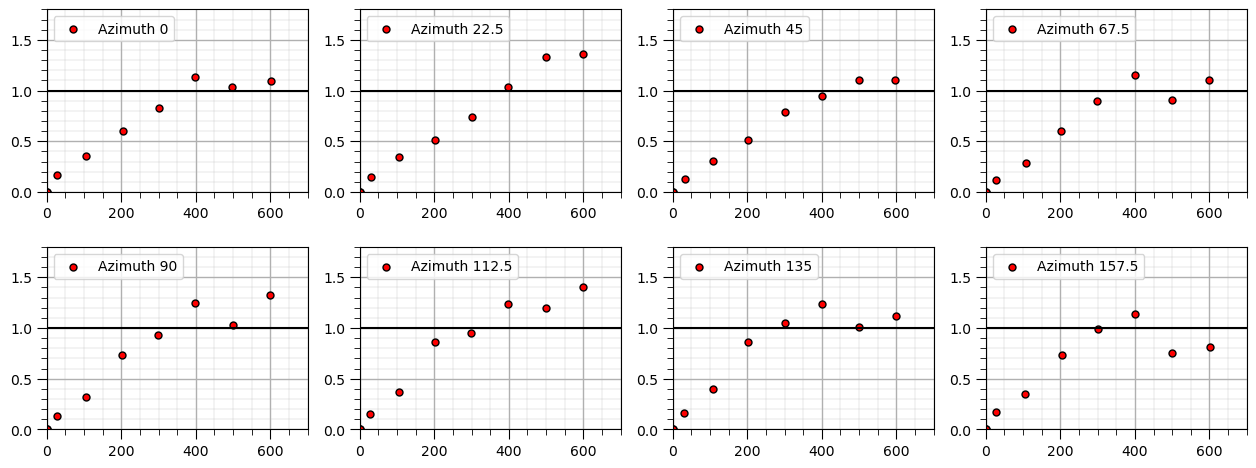

In [6]:
# Running these variograms and visualizing them on separate plots.  ...  loop over each direction for efficiency (and code brevity).
tmin = -9999.9; tmax = 9999.9   ; lag = np.zeros((len(azi_mat),nlag+2)); gamma = np.zeros((len(azi_mat),nlag+2)); npp = np.zeros((len(azi_mat),nlag+2));

fig = plt.figure(figsize=(3,2))
for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    lag[iazi,:], gamma[iazi,:], npp[iazi,:] = geostats.gamv(df,"X","Y","NPor",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
    plt.subplot(2,4,iazi+1)                          ; plt.scatter(lag[iazi,:],gamma[iazi,:],marker='o',color ='red',edgecolor='black',s = 25, label = 'Azimuth ' +str(azi_mat[iazi]))
    plt.plot([0,2000],[1.0,1.0],color = 'black')     ; plt.xlim([0,700]); plt.ylim([0,1.8]); plt.legend(loc='upper left'); add_grid()   

plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=2.1, wspace=0.2, hspace=0.3) ; plt.show()

* We can observe that Azimuth 045 is the major direction and Azimuth 135 is the minor direction. // This is a very powerful tool for exploring directionality in spatial datasets. Indeed!
